# Rede Neural Recorrente - Série Temporal com vários previsores

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

%matplotlib inline

## Obter os dados de treino

In [2]:
data_train = pd.read_csv("petr4-treinamento.csv")

In [3]:
data_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-01-02,19.990000,20.209999,19.690001,19.690001,18.086271,30182600.0
1,2013-01-03,19.809999,20.400000,19.700001,20.400000,18.738441,30552600.0
2,2013-01-04,20.330000,20.620001,20.170000,20.430000,18.766001,36141000.0
3,2013-01-07,20.480000,20.670000,19.950001,20.080000,18.444506,28069600.0
4,2013-01-08,20.110001,20.230000,19.459999,19.500000,17.911745,29091300.0


## Pré-Processamento dos dados de treino - Apagar dados Ausentes

In [4]:
# Só existem valores ausentes nos dados de treino
data_train.isnull().sum()

Date         0
Open         3
High         3
Low          3
Close        3
Adj Close    3
Volume       3
dtype: int64

In [5]:
# Tamanho original do dataset de treino
data_train.shape

(1245, 7)

In [6]:
# Como apenas 3 linhas têm valores ausentes optou-se por apagar essas linhas.
data_train = data_train.dropna()

In [7]:
# Confirmação de ter-se removido apenas 3 linhas
data_train.shape

(1242, 7)

In [8]:
# Confirmação da anão existencia de valores nulos
data_train.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

## Pré-Processamento dos dados de treino- Normalização das Variaveis

In [9]:
from sklearn.preprocessing import MinMaxScaler

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))

In [11]:
# Normalizar as variaveis
# Vão-se mormalizar todas as variaveis menos a data porque vão ser utilizadas para fazer o treino do modelo.
scaler.fit(data_train.drop(["Date"], axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [12]:
# Array com as variaveis normalizadas
open_norm_train = scaler.fit_transform(data_train.drop(["Date"], axis=1))

In [13]:
open_norm_train.shape

(1242, 6)

In [14]:
open_norm_train[:,0]

array([0.76501938, 0.7562984 , 0.78149225, ..., 0.57122093, 0.57655039,
       0.57655039])

## Divisão dos dados de treino

In [15]:
# Utilizar todas as variaveis para prever o preço de abertura das acções.
open_norm_train.shape

(1242, 6)

In [16]:
# Prever o preço das acções com base nos preços de abertura nos 90 dias anteriores.

X_train = [] # vector com os preços e volume nos 90 dias anteriores.
y_train = [] # vector com o preço de abertura da acção no dia 91.

In [17]:
# Só é possivel prever o preço das acções desde o dia 90 até ao dia 1242. Porque só se tem registro de 1242 dias e 
# estabeleceu-se como critério utilizar os 90 dias anteriores para fazer uma previsão.

for i in range(90, 1242):
    X_train.append(open_norm_train[i-90:i,0:6]) # valores dos preços e volume
    y_train.append(open_norm_train[i, 0]) # valor do preço de abertura

In [18]:
# Converter os vectores(listas) em arrays
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
# 1152 registros com os 90 dias anteriores para as 6 variaveis utilizadas para fazer a previsão.
# Para prever o preço nestes 1152 dias utilizam-se os 90 dias anteriores a cada dia a prever.
X_train.shape

(1152, 90, 6)

In [20]:
# X_train[0,:,0]: preços de abertura nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_train[0,:,1]: preços de máximo nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_train[0,:,2]: preços de minimo nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_train[0,:,3]: preços de fecho nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_train[0,:,4]: preços de fecho ajustado nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_train[0,:,5]: volume transaccionado nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_train[1,:,5]: volume transaccionado entre o dia 1 e 91. Utilizado para prever o preço de abertura no dia 92.

X_train[0,:,0]

array([0.76501938, 0.7562984 , 0.78149225, 0.78875969, 0.77083338,
       0.74806197, 0.75436047, 0.75823643, 0.76598837, 0.76598837,
       0.76017437, 0.75872098, 0.75581391, 0.74467054, 0.7374031 ,
       0.7374031 , 0.73498067, 0.75242248, 0.73401163, 0.71656977,
       0.68120155, 0.67538755, 0.67635659, 0.63372098, 0.66521318,
       0.65649225, 0.64680228, 0.66618222, 0.65843028, 0.64970935,
       0.65116274, 0.66424419, 0.67344961, 0.64292631, 0.64486434,
       0.62257747, 0.60949617, 0.60998067, 0.60852713, 0.59593023,
       0.61143411, 0.60222863, 0.64922481, 0.68362398, 0.70687989,
       0.68265509, 0.70978682, 0.70784879, 0.71608527, 0.73643411,
       0.7122093 , 0.7122093 , 0.7194767 , 0.70348832, 0.69525189,
       0.70397287, 0.70397287, 0.69767442, 0.68168605, 0.68168605,
       0.65310078, 0.66618222, 0.64825581, 0.66182175, 0.64341085,
       0.67877902, 0.69137592, 0.66569772, 0.65406982, 0.64292631,
       0.64147292, 0.63565891, 0.67587209, 0.68653106, 0.70300

In [21]:
# y_train[0:1]: preço de abertura (normalizado) no dia 91.
# y_train[1:2] preço de abertura (normalizado) no dia 92.
y_train[0:1]

array([0.76114341])

In [22]:
# A camada de entrada tem de ser um tensor 3d (input_shape, timesteps, input_dim)
# input_shape: 1152 registros. Número de registros totais
# timesteps: 90 registros. Número de registros utilizados para fazer a previsão.
#input_dim: 6 indicador(6 variaveis de entrada utilizadas para fazer a previsão).

# Não é necessário porque o array já está no formato correcto
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 6))

## Modelo Rede Neural Recorrente

In [23]:
# sequential - A informação é passada de uma camada para a camada seguinte

#-------------------------------------------------------------------------------------------------------------------------------
# Camada LSTM

# LSTM - Long short term memory. AS redes neurais simples têm dificuldade em "aprender" alguns tipos de padrões mais complexos.
# Nesses casos pode-se utilizar o tipo de rede neural recorrente LSTM que aprende "dependencias" de longo prazo.

# As redes neurais recorrentes simples armazenam as informações no tempo atraves de loops( o neuronio apenas aponta para ele 
# mesmo e para a camada seguinte). Isto permte que a informação persista.
# As redes neurais recorrentes LSTM para alem disso têm celulas de memoria e manipulam essas celulas de modo a filtrar e 
# armazenar a informação importante nessas celulas.

# As redes neurais recorrentes ajudam no problema do gradiente desaparecendo(vanish gradient). No ajuste dos pesos ao se
# utilizar a descida do gradiente e a sua actualização atraves de backpropagation em primeiro faz-se os calculos da camada
# de entrada para a camada de saida. Os pesos são depois actalizados a partir da camada de saida para a camada de entrada. Os
# pesos vão sendo actualizados utilizando o learning rate(maiores alterações nas 1ªs camadas). Caso se tenha muitos loops
# as ultimas actualizações do gradiente são muito pequenas, o que faz com que o peso não tenha alteração no seu valor.

# Número de celulas de memoria(units): Número de vezes(loops) em que a informação é passada ao mesmo neuronio e a camada 
# seguinte (numero de cópias da camada). Deve ser um valor alto para adicinonar mais dimensionalidade e decorar a tendencia ao 
# longo do tempo.

# Return_sequence: True. Apenas se utilizada quando se tem mais de uma camada LSTM. Indica que a informação será passada para a
# camada seguinte.

# input_shape: Número de registros utilizados para fazer a previsão(90) e número de variaveis de entrada(6).
#-------------------------------------------------------------------------------------------------------------------------------
# Camada densa

# Todos os neuronios da ultima camada( segunda camada LSTM) estão conectados à camada de saida. Nas camadas LSTM isso tambem
# acontece.

# units: 1. Só se quer prever o valor Open.
# activation: linear. É um problema de regressão. Como os valores estão normalizados(entre 0 e 1) caso se utiliza-se a função
# sigmoid tambem se retornaria valores entre 0 e 1.
#-------------------------------------------------------------------------------------------------------------------------------

model = models.Sequential()
model.add(layers.LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], 6)))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50, return_sequences=True))
model.add(layers.Dropout(0.3))

model.add(layers.LSTM(units=50))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(units=1, activation="sigmoid"))

## Compilação e Ajuste do modelo RNN

In [24]:
# optimizer: pode-se utilizar o RMSprop, indicado para redes neurais recorrentes, ou o adam que obtem resultados semelhantes.
# loss: mean_squared_error é o parametro utilizado para problemas de regressão.

# Compilação do modelo
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_absolute_error"])

In [25]:
# callbacks: contem um conjunto de funções que podem ser aplicadas durante o treino. São usadas para se ter uma visão das fases
# internas e estatisticas do modelo.

# EarlyStopping: Pára o treino se uma quantidade definida parar de melhorar.Por exemplo se durante 30 épocas o valor da loss 

# function não melhorar, o treino é parado.
# monitor: função a avaliar
# min_delta: valor minimo definido da function para se continuar o treino. Se esse valor não for atingido durante "patiente" 
# épocas o treino pára.
# patience: número de epocas em que a função não melhorar. Se durante estas epocas a função não melhorar o treino pára.

es = callbacks.EarlyStopping(monitor="loss", min_delta=1e-10, patience=10, verbose=1)

In [26]:
# ReduceLROnPlateau(): Reduz a taxa de aprendizagem quando uma função pára de melhorar.
# Se a loss function não melhorar depois de, por exemplo 2 ou 3 epocas, reduz a taxa de aprendizagem para melhorar o valor da
# função.

# factor: factor pelo qual a learning rateé reduzida, factorxlr()
# min_delta: 

rlr = callbacks.ReduceLROnPlateau(monitor="loss", patience=5, factor=0.2, verbose=1)

In [27]:
# Gráva o modelo no fim de cada época

# monitor: função a avaliar
# save_best_only: grava apenas o modelo com o melhor resultado

ncp = callbacks.ModelCheckpoint(monitor="loss", save_best_only=True, filepath="pesos.h5", verbose=1)

In [28]:
# Ajustar os dados de entrada de treino aos dados de saida para treinar o modelo.
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[es, rlr, ncp])

Train on 1152 samples
Epoch 1/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0193 - mean_absolute_error: 0.1054
Epoch 00001: loss improved from inf to 0.01891, saving model to pesos.h5
1152/1152 [==============================] - 11s 9ms/sample - loss: 0.0189 - mean_absolute_error: 0.1042
Epoch 2/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0053 - mean_absolute_error: 0.0580
Epoch 00002: loss improved from 0.01891 to 0.00526, saving model to pesos.h5
1152/1152 [==============================] - 9s 7ms/sample - loss: 0.0053 - mean_absolute_error: 0.0575
Epoch 3/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0040 - mean_absolute_error: 0.0496
Epoch 00003: loss improved from 0.00526 to 0.00404, saving model to pesos.h5
1152/1152 [==============================] - 9s 8ms/sample - loss: 0.0040 - mean_absolute_error: 0.0497
Epoch 4/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0042 - mean_absolute_error: 0.050

Epoch 30/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0015 - mean_absolute_error: 0.0297
Epoch 00030: loss did not improve from 0.00140
1152/1152 [==============================] - 9s 8ms/sample - loss: 0.0015 - mean_absolute_error: 0.0298
Epoch 31/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0286
Epoch 00031: loss did not improve from 0.00140
1152/1152 [==============================] - 9s 7ms/sample - loss: 0.0014 - mean_absolute_error: 0.0285
Epoch 32/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0013 - mean_absolute_error: 0.0276
Epoch 00032: loss improved from 0.00140 to 0.00136, saving model to pesos.h5
1152/1152 [==============================] - 9s 7ms/sample - loss: 0.0014 - mean_absolute_error: 0.0278
Epoch 33/100
1120/1152 [============================>.] - ETA: 0s - loss: 0.0014 - mean_absolute_error: 0.0282
Epoch 00033: loss did not improve from 0.00136
1152/1152 [===============

## Obter os dados de teste

In [29]:
data_test = pd.read_csv("petr4-teste.csv")

In [30]:
data_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,16.190001,16.549999,16.190001,16.549999,16.516966,33461800
1,2018-01-03,16.490000,16.719999,16.370001,16.700001,16.666668,55940900
2,2018-01-04,16.780001,16.959999,16.620001,16.730000,16.696608,37064900
3,2018-01-05,16.700001,16.860001,16.570000,16.830000,16.796408,26958200
4,2018-01-08,16.740000,17.030001,16.709999,17.030001,16.996010,28400000


In [31]:
data_test.shape

(22, 7)

In [32]:
# lista com os dados totais
data_total = [data_train, data_test]

In [33]:
# Converter a lista data_total em dataframe
data_total = pd.concat(data_total)

In [34]:
# data_train tem os dados desde 2013-01-02 até 2017-12-29
# data_teste tem os dados desde 2018-01-02 até 2018-01-31
# data tem dos dados desde 2013-01-02 até 2018-01-31

# 1242+22 = 1264 registros com 7 variaveis
data_total.shape

(1264, 7)

In [35]:
# Retirar a variavel date que não é utilizada para fazer previsões
data_total = data_total.drop("Date", axis=1)

In [36]:
# dados desde 2017-08-28 até 2018-01-31
data_total_test = data_total[len(data_total) - len(data_test)-90:].values

In [37]:
# 22+90=112 dias de preços e volume
# O X_test contem os 22 dias da base de dados de teste mais os 90 dias anteriores. Esses 90 dias anteriores são necessários 
# para se poderem fazer previssões.
data_total_test.shape

(112, 6)

In [81]:
data_total_test[1,0]

13.76

## Pré-Processamento dos dados de teste - Normalização das Variaveis

In [38]:
# Normalizar as variaveis de entrada
# Não é necessário fazer o fit porque já foi feito anteriormente no treino.
data_total_test_norm =scaler.transform(data_total_test)

In [41]:
data_total_test_norm.shape

(112, 6)

In [89]:
# Variavel Open normalizada com o scaler
data_total_test_norm[1:5,0]

array([0.46317829, 0.46463178, 0.45203488, 0.46753876])

In [43]:
# O array predictions é tem a dimensão (112,1). Quando se inverter a normalização tem de se utilizar um normalizador que esteja
# ajustado por essa dimensão.
# O scaler está ajustado para a dimensão (112,6) por isso não pode ser utilizado para reverter a normalização do array 
# predictions.

scaler_prediction = MinMaxScaler()

In [44]:
# Ajustar e normalizar a variavel Open
# Tem de se utilizar a mesma base de dados de treino para que a escala seja a mesma.

pred = scaler_prediction.fit_transform(data_train.drop(["Date", "High", "Low", "Close", "Adj Close", "Volume"], axis=1))

In [92]:
# A variavel Open normalizada é igual fazendo a normalização com o scaler ou com o scaler_prediction.
pred[1153:1157]

array([[0.46317829],
       [0.46463178],
       [0.45203488],
       [0.46753876]])

In [51]:
pred.shape

(1242, 1)

## Divisão dos dados de teste

In [52]:
# Prever o preço de abertura das acções com base nos preços de abertura nos 90 dias anteriores.

X_test = [] # vector com os preços e volume nos 90 dias anteriores.
y_test = [] # vector com o preço de abertura da acção no dia 91.

In [53]:
for i in range(90, 112):
    X_test.append(data_total_test_norm[i-90:i, 0:6]) # valores dos preços e volume
    y_test.append(data_total_test_norm[i,0]) # valor do preço de abertura

In [54]:
# Converter as listas em arrays
X_test, y_test = np.array(X_test), np.array(y_test)

In [55]:
# 22 registros com os 90 dias anteriores para as 6 variaveis utilizadas para fazer a previsão.
# Para prever o preço nestes 22 dias utilizam-se os 90 dias anteriores a cada dia a prever.
X_test.shape

(22, 90, 6)

In [56]:
# X_test[0,:,0]: preços de abertura nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_test[0,:,1]: preços de máximo nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_test[0,:,2]: preços de minimo nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_test[0,:,3]: preços de fecho nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_test[0,:,4]: preços de fecho ajustado nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_test[0,:,5]: volume transaccionado nos primeiros 90 dias. Utilizado para prever o preço de abertura no dia 91.
# X_test[1,:,5]: volume transaccionado entre o dia 1 e 91. Utilizado para prever o preço de abertura no dia 92.

X_test[0,:,0]

array([0.47141473, 0.46317829, 0.46463178, 0.45203488, 0.46753876,
       0.47286822, 0.50242248, 0.50629845, 0.52422481, 0.52810078,
       0.51744186, 0.52228682, 0.52034884, 0.5247093 , 0.52664729,
       0.52422481, 0.52810078, 0.53536822, 0.56443798, 0.55232558,
       0.56153101, 0.56492248, 0.55717054, 0.54118217, 0.54748062,
       0.53246124, 0.55232558, 0.56686047, 0.56589147, 0.55523256,
       0.55281008, 0.57800383, 0.57994186, 0.5755814 , 0.58284884,
       0.57945736, 0.57848832, 0.58236429, 0.57170543, 0.5809109 ,
       0.58575586, 0.58575586, 0.59738377, 0.60949617, 0.60901163,
       0.6187015 , 0.61531008, 0.61967054, 0.61531008, 0.61821701,
       0.62257747, 0.63517437, 0.60513571, 0.61482553, 0.6061046 ,
       0.60513571, 0.60271313, 0.54021318, 0.55329457, 0.56782946,
       0.57267442, 0.57897287, 0.57606589, 0.57073643, 0.58381783,
       0.57218992, 0.56831395, 0.56540698, 0.5377907 , 0.53972868,
       0.55474806, 0.54748062, 0.53391473, 0.5377907 , 0.54796

In [57]:
# y_test[0:1]: preço de abertura (normalizado) no dia 91.
# y_test[1:2] preço de abertura (normalizado) no dia 92.
y_test[0:1]

array([0.5809109])

In [58]:
# A camada de entrada tem de ser um tensor 3d (input_shape, timesteps, input_dim)
# input_shape: 22 registros. Número de registros totais de teste
# timesteps: 90 registros. Número de registros utilizados para fazer a previsão.
#input_dim: 6 indicador(apenas 6 variavel de entrada)

# Não é necessário porque o array já está no formato correcto
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 6))

## Previsão e Avaliação do Modelo RNN

In [59]:
# Prever os dados de teste para avaliar o modelo
predictions = model.predict(X_test)

In [60]:
# Reverter a normalização do X_test para comparar os valores das acções
predictions = scaler_prediction.inverse_transform(predictions)

In [61]:
# Reverter a normalização do y_test para comparar os valores das acções
y_test = scaler_prediction.inverse_transform(y_test.reshape(-1,1))

In [62]:
pd.DataFrame({"Predictions": predictions[:,0], "y_test":y_test[:,0]}).head()

,Predictions,y_test
0,16.130117,16.190001
1,16.215849,16.490000
2,16.376980,16.780001
3,16.598076,16.700001
4,16.802332,16.740000


### Avaliação do Modelo

In [63]:
from sklearn import metrics

In [64]:
# O MSE é muito mais elevado porque penaliza os desvios grandes(são elevados ao quadrado).
# O MAE de 0.36 significa que o preço das acções varia +- 0.36 reais. 
print("MAE", metrics.mean_absolute_error(y_test, predictions))
print("MSE", metrics.mean_squared_error(y_test, predictions))
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE 0.2603642565252136
MSE 0.13638905150793906
RMSE 0.36930888360278996


In [65]:
predictions.mean()

17.658825

In [66]:
data_test["Open"].mean()

17.874545636363635

### Resíduos

Text(0.5, 0, 'y_test-predictions')

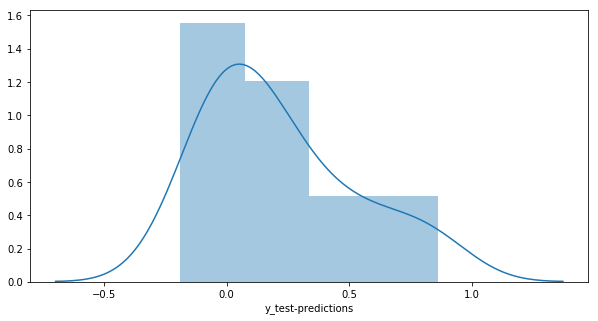

In [67]:
# Histograma de Residuos 
# O gráfico não parece aproximar-se de uma distriuição normal, onde os residuos são proximos de zero.

plt.figure(figsize=(10,5))
sns.distplot(y_test-predictions)
plt.xlabel("y_test-predictions")

### Gráfico preço real vs preço previsto

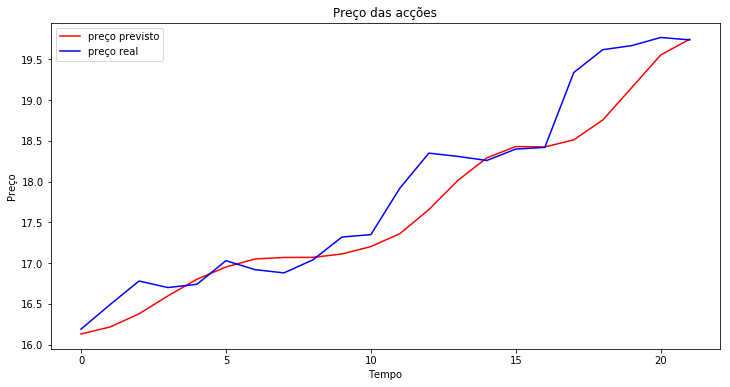

In [68]:
plt.figure(figsize=(12,6))
plt.plot(predictions, color="red", label="preço previsto")
plt.plot(y_test, color="blue", label="preço real")
plt.title("Preço das acções")
plt.xlabel("Tempo")
plt.ylabel("Preço")
plt.legend()
plt.show()